In [ ]:
import os
import random
import time
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
from torchvision import datasets
from torchvision.transforms import ToTensor
import shutil
from pathlib import Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle"
# /content/drive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/drive/My Drive/Kaggle

/content/drive/My Drive/Kaggle


In [ ]:
 !kaggle datasets download -d splcher/animefacedataset

 98% 387M/395M [00:01<00:00, 294MB/s]
100% 395M/395M [00:01<00:00, 279MB/s]


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip

In [ ]:
# device setup
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Hyperparameters
generator_learning_rate = 0.0002
discriminator_learning_rate = 0.0002

num_epochs = 20
batch_size = 128

img_height, img_width, img_channels = 64, 64, 3

data_dir = "/content/drive/My Drive/Kaggle"

#setting custom transforms
custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize([img_height, img_width]),
    torchvision.transforms.CenterCrop((img_height,img_width)),
    torchvision.transforms.ToTensor(), #converts image to pytorch tensor to [0,1] range
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #images are normalized to be within [-1,1]
])

train_dataset = dset.ImageFolder(root=data_dir,
                           transform=custom_transforms)

# Creating the dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

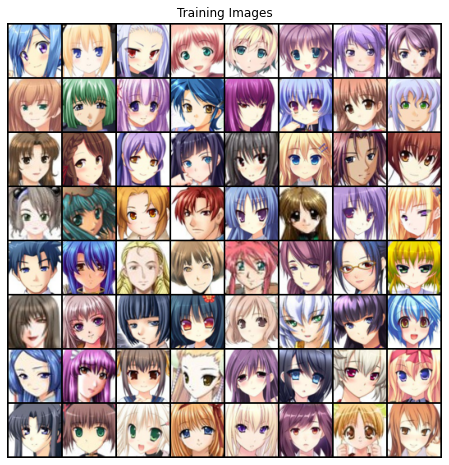

In [ ]:
# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    break

Training Set:

Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128])


# The DCGAN architecture

Generator part of the GANs architecture, as implemented in the Chintala(2015) paper. <br>

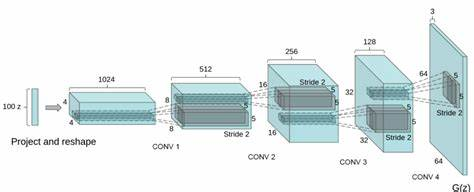

In [ ]:
class DCGAN(torch.nn.Module):

    def __init__(self, latent_dim=100, num_feat_maps_gen=64,
                 num_feat_maps_dis=64,color_channels=3):
        super().__init__()
        
        #setting up the Generator module
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, num_feat_maps_gen*16, 
                               kernel_size=4, stride=1, padding=0,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*16),
            nn.LeakyReLU(inplace=True),
            ##
            nn.ConvTranspose2d(num_feat_maps_gen*16, num_feat_maps_gen*8, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*8),
            nn.LeakyReLU(inplace=True),
            ##
            nn.ConvTranspose2d(num_feat_maps_gen*8, num_feat_maps_gen*4, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*4),
            nn.LeakyReLU(inplace=True),
            ##
            nn.ConvTranspose2d(num_feat_maps_gen*4, num_feat_maps_gen*2, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*2),
            nn.LeakyReLU(inplace=True),
            ##
            nn.ConvTranspose2d(num_feat_maps_gen*2, color_channels, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            
            ## size : color_channels x 64 x 64
              
            nn.Tanh() # since images are normalized to be within [-1,1] , 
            #we'd want that our generator also outputs in the same range
        )
        
        #setting up the discriminator module
        self.discriminator = nn.Sequential(
            
            # input size -> color_channels x image_height x image_width
            
            nn.Conv2d(color_channels, num_feat_maps_dis,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),
            ##      
            nn.Conv2d(num_feat_maps_dis, num_feat_maps_dis*2,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*2),
            nn.LeakyReLU(inplace=True),
            ##
            nn.Conv2d(num_feat_maps_dis*2, num_feat_maps_dis*4,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*4),
            nn.LeakyReLU(inplace=True),
            ## 
            nn.Conv2d(num_feat_maps_dis*4, num_feat_maps_dis*8,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*8),
            nn.LeakyReLU(inplace=True),
            ##  
            nn.Conv2d(num_feat_maps_dis*8, 1,
                      kernel_size=4, stride=1, padding=0),
            
            # size -> 1 x 1 x 1
            nn.Flatten(),

            # nn.Sigmoid(), : not used here, instead binary_cross_entropy_with_logits 
            #                 is used for numerical stability when calculating loss

            
        )

            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        logits = model.discriminator(img)
        return logits

In [ ]:
model = DCGAN()
model.to(device)


optim_gen = torch.optim.Adam(model.generator.parameters(), betas=(0.5, 0.999),lr=generator_learning_rate)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),betas=(0.5, 0.999),lr=discriminator_learning_rate)

#We use distinct optimizers because we need to alternatively discriminator and generator alternatively

In [ ]:
## Used some tips and tricks from here to set up the training loop (https://github.com/soumith/ganhacks)

def train_gan_v1(num_epochs, model, optimizer_gen, optimizer_discr, latent_dim, device, train_loader, loss_fn=None,logging_interval=200,
                 save_model=None):
    
    log_dict = {'train_generator_loss_per_batch': [],
                'train_discriminator_loss_per_batch': [],
                'train_discriminator_real_acc_per_batch': [],
                'train_discriminator_fake_acc_per_batch': [],
                'images_from_noise_per_epoch': []}

    if loss_fn is None:
        loss_fn = torch.nn.functional.binary_cross_entropy_with_logits
        #could have used nll_loss with sigmoid, but binary_cross_entropy_with_logits provides numerical stability

    # Batch of latent (noise) vectors for evaluating results during training
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device) # format NCHW

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            batch_size = features.size(0)

            real_images = features.to(device) # putting the real images on the GPU
            real_labels = torch.ones(batch_size, device=device) # real label = 1 , we provide these class labels to the discriminator

            # generated (fake) images
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # format NCHW
            fake_images = model.generator_forward(noise)
            fake_labels = torch.zeros(batch_size, device=device) # fake label = 0 , once again we provide these class labels to the discriminator

            # 1. Train Discriminator

            optimizer_discr.zero_grad()
            # 1.1 Assigning label 1 to all the real images so that our discriminator learns to predict the real images correctly

            discr_pred_real = model.discriminator_forward(real_images).view(-1) # Nx1 -> N
            real_loss = loss_fn(discr_pred_real, real_labels)

            # 1.2 Assigning label 0 to the output of the generator
            discr_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1) #.detach to prevent gradient computation
            fake_loss = loss_fn(discr_pred_fake, fake_labels)
            ## This step is akin to freezing the generator parameters and train the discriminator on the output of the generator,
            ## but because I have taken distinct optimizers for discriminator and generator, I are just updating the discriminator's parameters in the step
            ## and not touching the generator's parameters

            # calculating the combined loss
            discr_loss = 0.5*(real_loss + fake_loss)
            discr_loss.backward()
            
            #updating the discriminator's parameters
            optimizer_discr.step()

            ## 2. Training the Generator

            optimizer_gen.zero_grad()

            # freezing the discriminator and updating the parameters of the generator
            # the goal is to learn to fool the discriminator , so that the discriminator thinks that these generated images are real images
            # this is the stage where the generator tries to learn the training set distribution
            
            flipped_fake_labels = real_labels # here, we flip the labels to 1 to fool the discriminator
            discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
            gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
            gener_loss.backward()

            optimizer_gen.step()

            # Logging

            log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
            log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())
            
            predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
            predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
            acc_real = (predicted_labels_real == real_labels).float().mean()*100.
            acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
            log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
            log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())         
            
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                       % (epoch+1, num_epochs, batch_idx, 
                          len(train_loader), gener_loss.item(), discr_loss.item()))

        # Save images for evaluation
        with torch.no_grad():
            fake_images = model.generator_forward(fixed_noise).detach().cpu()
            log_dict['images_from_noise_per_epoch'].append(
                torchvision.utils.make_grid(fake_images, padding=2, normalize=True))


        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict


log_dict = train_gan_v1(num_epochs=num_epochs, model=model, optimizer_gen=optim_gen, optimizer_discr=optim_discr,
                        latent_dim=100, ## 100 elements are sampled from the random normal distribution
                        device=device, train_loader=train_loader,logging_interval=200, save_model='dcgan_anime.pt')

Epoch: 001/020 | Batch 000/497 | Gen/Dis Loss: 3.5538/0.2746
Epoch: 001/020 | Batch 200/497 | Gen/Dis Loss: 5.1358/0.2833
Epoch: 001/020 | Batch 400/497 | Gen/Dis Loss: 2.5060/0.2931
Time elapsed: 2.83 min
Epoch: 002/020 | Batch 000/497 | Gen/Dis Loss: 2.6268/0.2262
Epoch: 002/020 | Batch 200/497 | Gen/Dis Loss: 3.3342/0.1848
Epoch: 002/020 | Batch 400/497 | Gen/Dis Loss: 3.7892/0.1392
Time elapsed: 5.67 min
Epoch: 003/020 | Batch 000/497 | Gen/Dis Loss: 4.0078/0.1826
Epoch: 003/020 | Batch 200/497 | Gen/Dis Loss: 2.5759/0.1708
Epoch: 003/020 | Batch 400/497 | Gen/Dis Loss: 4.7594/0.2120
Time elapsed: 8.51 min
Epoch: 004/020 | Batch 000/497 | Gen/Dis Loss: 3.7565/0.1243
Epoch: 004/020 | Batch 200/497 | Gen/Dis Loss: 2.8942/0.1677
Epoch: 004/020 | Batch 400/497 | Gen/Dis Loss: 3.9248/0.1904
Time elapsed: 11.33 min
Epoch: 005/020 | Batch 000/497 | Gen/Dis Loss: 2.9384/0.1428
Epoch: 005/020 | Batch 200/497 | Gen/Dis Loss: 8.1351/0.3296
Epoch: 005/020 | Batch 400/497 | Gen/Dis Loss: 2.5384

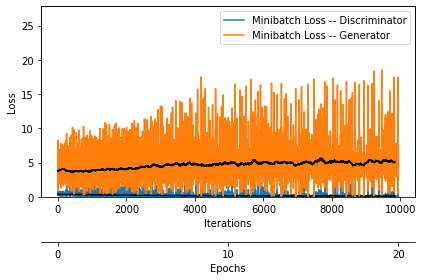

In [ ]:
def plot_multiple_training_losses(losses_list, num_epochs,
                                  averaging_iterations=100, custom_labels_list=None):

    for i, _ in enumerate(losses_list):
        if not len(losses_list[i]) == len(losses_list[0]):
            raise ValueError('All loss tensors need to have the same number of elements.')

    if custom_labels_list is None:
        custom_labels_list = [str(i) for i,_ in enumerate(custom_labels_list)]

    iter_per_epoch = len(losses_list[0]) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)

    for i, minibatch_loss_tensor in enumerate(losses_list):
        ax1.plot(range(len(minibatch_loss_tensor)),
                 (minibatch_loss_tensor),
                  label=f'Minibatch Loss{custom_labels_list[i]}')
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Loss')

        ax1.plot(np.convolve(minibatch_loss_tensor,
                             np.ones(averaging_iterations,)/averaging_iterations,
                             mode='valid'),
                 color='black')

    if len(losses_list[0]) < 1000:
        num_losses = len(losses_list[0]) // 2
    else:
        num_losses = 1000
    maxes = [np.max(losses_list[i][num_losses:]) for i, _ in enumerate(losses_list)]
    ax1.set_ylim([0, np.max(maxes)*1.5])
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()



plot_multiple_training_losses(
    losses_list=(log_dict['train_discriminator_loss_per_batch'],
                 log_dict['train_generator_loss_per_batch']),
    num_epochs=num_epochs, 
    custom_labels_list=(' -- Discriminator', ' -- Generator')
)

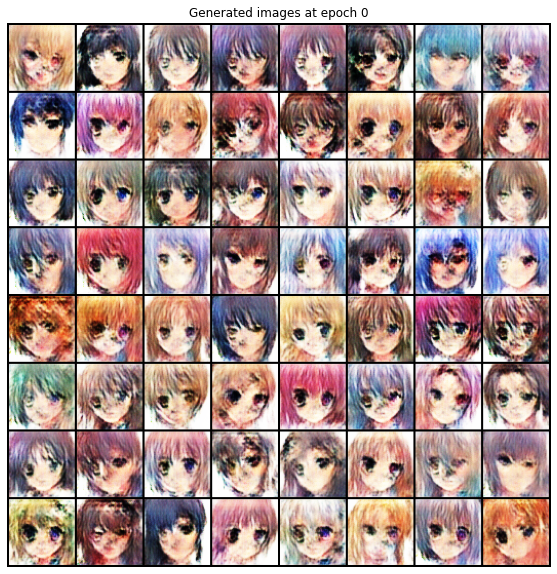

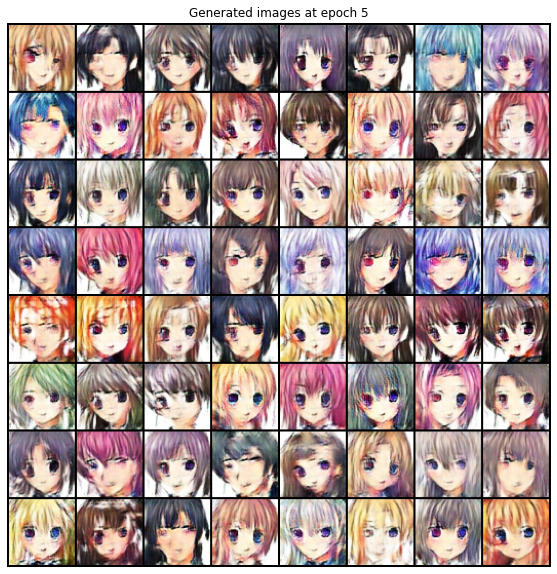

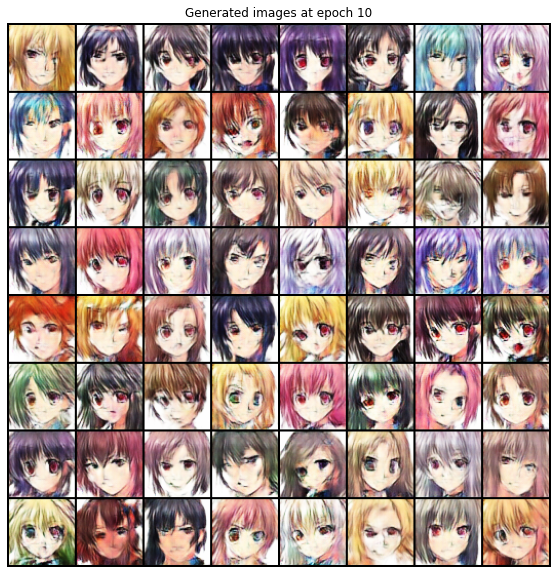

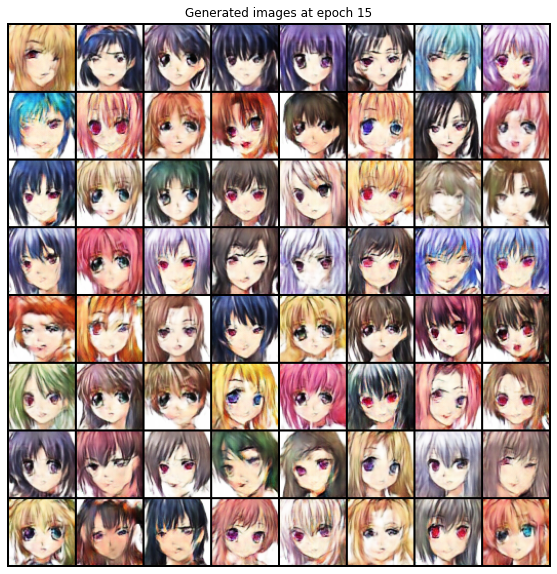

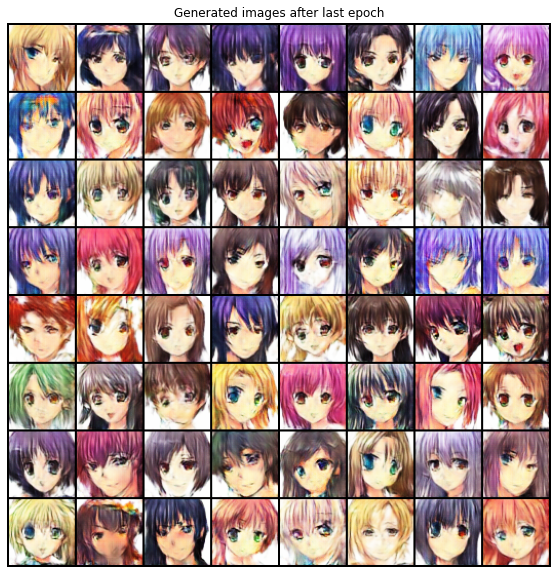

In [ ]:
for i in range(0,num_epochs, 5):
    
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()
    
    
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()